<a href="https://colab.research.google.com/github/Coyote-Schmoyote/portrait-generation-dcgan/blob/main/GAN_portriat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image generation with GAN
This notebook looks into the process of generating images using GAN. The first part of the notebook covers the workflow of building a simple GAN using an example of simple handwritten digit image generation. It is meant to serve as an introduction to the second part of the notebook, art portrait generation with DCGAN. The project is inspired by the AI-generated portrait of Edmond de Belamy (2018) that was sold at Christie's for $432,000. 
## 1. Problem Definition
Generate new images based on the input images from the dataset.
## 2. Data
The data used in this project is the Portrait Paintings dataset available on Kaggle (https://www.kaggle.com/datasets/deewakarchakraborty/portrait-paintings). The dataset consists of 5734 images of portrait paintings created between 1859 to 1950.
## 3. Approach
For this project, we will use Generative Adversarial Network (GAN) for MNIST digit generation, and Deep Convolutional Generative Adversarial Network (DCGAN) for art portrait generation.

##4. Evaluation
There is no function to evaluate the performance of a GAN model, which means that the performance of the model will be evaluated based on the quality of the generated images.

In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import random 
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import preprocessing

In [3]:
project_folder = "/content/drive/MyDrive/ml-projects/GAN/portraits/Images/"

## Data Preparation
The goal of this project was to generate a portrait based on the input images. The original dataset consists of 5734 images of portraits. 
Following my artistic vision, I decided that I want to generate portraits that fulfill the following criteria:
* Front-facing portrait
* Half-length
* Colored (not monochrome)
* Painted (i.e. not pencil drawing or print)
* Adult

To recevie this result, I followed the  rule "garbage in, garbage out" by removing images that depict full-body portraits, have more than one person in the image, side portaits, too abstract portraits (where it is impossible to tell wether an image depicts a face), portraits of children, black and white portraits, pencil drawings and prints.


Depending on your **artistic vision**, you can experiment with the dataset, for example, use only images depicting subjects of one gender, using images created only by one artist, using images only of a particular color scheme, etc.

Depending on your idea, the process of cleaning the dataset might take several hours. 

In [4]:
image_list = os.listdir(project_folder)
print(f"Number of images after data cleaning: {len(image_list)}")

Number of images after data cleaning: 1936


In [5]:
def select_random_image(folder):
  img_list = os.listdir(folder)
  image = os.path.join(folder, random.choice(img_list))
  image = plt.imread(image)
  return image

def display_random_image(folder):
  image = select_random_image(folder)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Sample Portrait")

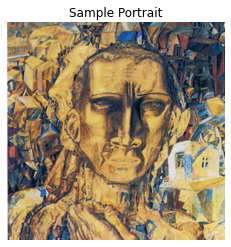

In [6]:
display_random_image(project_folder)

In [7]:
def display_random_images(folder):
  images = []
  for _ in range(4):
    images.append(select_random_image(folder))
  
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=len(images), sharey=True, figsize = (14, 7))
  fig.tight_layout()
  ax1.imshow(images[0])
  ax1.axis("off")
  ax2.imshow(images[1])
  ax2.axis("off")
  ax3.imshow(images[2])
  ax3.axis("off")
  ax4.imshow(images[3])
  ax4.axis("off");

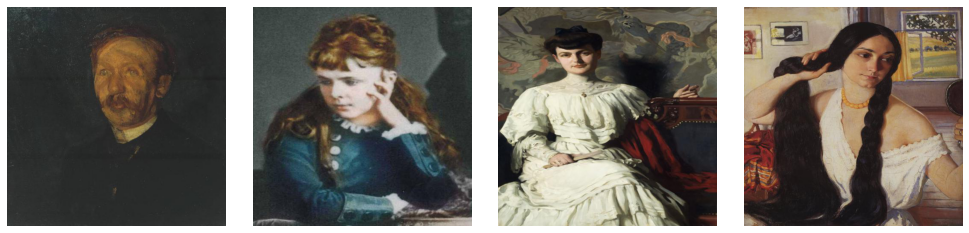

In [8]:
display_random_images(project_folder)

### Image Preprocessing
Before building our GAN, we need to make pre-process our images in the dataset. 


In [24]:
def create_image_array(path):
  for image in os.listdir(project_folder):
    image_array = cv2.imread(os.path.join(project_folder, image))
  return image_array

In [25]:
image_array = create_image_array(project_folder)

In [26]:
print(f"Original image shape: {image_array.shape}")

Original image shape: (512, 512, 3)


In [27]:
def display_resized_image(image, size):
  image = cv2.resize(image, (size, size))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  print(f"Resized {size}x{size}px image shape: {image.shape}")
  plt.imshow(image);

Resized 112x112px image shape: (112, 112, 3)


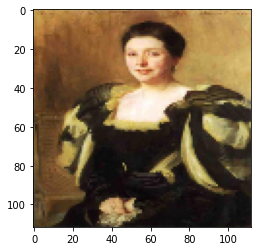

In [28]:
display_resized_image(image_array, 112)

Resized 64x64px image shape: (64, 64, 3)


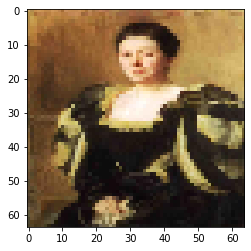

In [29]:
display_resized_image(image_array, 64)

Resized 23x23px image shape: (23, 23, 3)


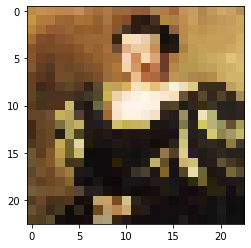

In [30]:
display_resized_image(image_array, 23)

In [40]:
def load_real_samples(path, size):
  real_samples = []
  for image in os.listdir(path):
    try:
      images = cv2.imread(os.path.join(path, image))
      images = cv2.resize(images, (size, size))
      real_samples.append(images)
    except Exception as e:
      pass
  return real_samples

In [41]:
size = 112
color_channels = 3
path=project_folder

dataset = load_real_samples(path, size)

In [42]:
print(f"Images in project folder: {len(os.listdir(project_folder))}, Images in dataset: {len(dataset)}")

Images in project folder: 1936, Images in dataset: 1935


In [65]:
def create_dataset(path, size, color_channels):
  real_samples = load_real_samples(path, size)
  dataset = np.array(real_samples).reshape(-1, size, size, color_channels) #-1 means any number
  dataset = dataset / 255.0
  return dataset


In [66]:
dataset = create_dataset(path, size, color_channels)
dataset.shape

(1935, 112, 112, 3)

## Keras API
In this project, we will use the Keras Sequential API to build our DCGAN network.
Keras is an API developed by Google that simplifies the process of building deep neural networks. Keras is built on top of TensorFlow 2, and provides inbuild modules for the majority of neural network computations, runs smoothly on CPU and GPU, supports almost all neural network models, and gained popularity for being flexible and fast.

Keras provides two ways of building deep neural network models: Sequential and functional. The sequential API allows us to create models layer-by-layer for most deep learning tasks. In this project, we will build a Sequential model. Functional models, on the other hand, are more complex, but allows more control over the resulting model architecture.


### DCGAN
For this project, we will implement the Deep Convolutional GAN (DCGAN) architecture.The goal of our project is to generate art portraits, based on the examples from the training dataset. This can be performed with both simple GAN and DCGAN, and  the initial process is essentially the same. 

The generator takes inpiut images to create new synthetic images that it can then pass to the discriminator. The discriminator has to recognize the authentic images from the ones created by the generator. It takes both real and fake images and returns probabilities between 0 and 1 of whether an image is real or fake. 
For DCGAN, the discriminator network is a typical convolutional network that categorizes images, and the generator is an inverse convolutional network, which takes a vector of random noise and upsamples it to an image. Because of this feature, it can produce more accurate images with less noise, compared to a simple GAN. 



In [47]:
def make_discriminator(in_shape=(112,112,3)):
  #instantiate the model
  model = keras.Sequential(name="Discriminator")

  #add 1st set of convolutional + normalization layers
  model.add(layers.Conv2D(112, kernel_size= 4, strides=2, padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(224, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(224, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #Add final flatten and output layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))

  #compile the model
  model.compile(loss = "binary_crossentropy", 
                optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                metrics = ["accuracy"])
  return model

In [48]:
discriminator = make_discriminator()

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 112)       5488      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 56, 56, 112)       0         
                                                                 
 dropout (Dropout)           (None, 56, 56, 112)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 224)       401632    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 224)       0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 224)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 224)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Input shape of generator must match the last conv layer of discriminator
* Latent_dim must match the number of filters in the input shape of generator

In [49]:
# make the generator
def make_generator(latent_dim):
	model = keras.Sequential(name="Generator")
 
	# foundation for 14x14 image
	n_nodes = 224 * 14 * 14
	model.add(layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((14, 14, 224)))
 
	# upsample to 28x28
	model.add(layers.Conv2DTranspose(224, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
	# upsample to 56x56
	model.add(layers.Conv2DTranspose(224, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 	# upsample to 112x
	model.add(layers.Conv2DTranspose(224, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 
	model.add(layers.Conv2D(3, (2,2), activation='sigmoid', padding='same'))
	return model

In [50]:
latent_dim = 224

generator = make_generator(latent_dim)
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 43904)             9878400   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 43904)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 224)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 224)      803040    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 224)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 56, 56, 224)      803040    
 ranspose)                                               

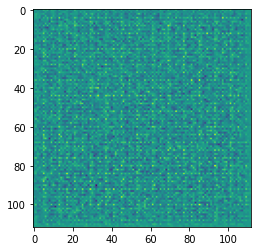

In [51]:
random_noise = tf.random.normal([1, 224])
generated_noise = generator(random_noise, training=False)

plt.imshow(generated_noise[0, :, :, 0]);

In [52]:
def make_gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential(name="GAN")

  #add generator
  model.add(generator)

  # add discriminator
  model.add(discriminator)

  #compile model
  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",
                optimizer=optimizer)
  return model

In [53]:
gan = make_gan(generator, discriminator)

gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 112, 112, 3)       12290211  
                                                                 
 Discriminator (Sequential)  (None, 1)                 1254065   
                                                                 
Total params: 13,544,276
Trainable params: 12,290,211
Non-trainable params: 1,254,065
_________________________________________________________________


In [67]:
def select_real_samples(dataset, n_samples):
  random_samples = np.random.randint(0, dataset.shape[0], n_samples)
  real_images = dataset[random_samples]
  real_labels = np.ones((n_samples, 1))
  return real_images, real_labels

In [68]:
def generate_latent_points(latent_dim, n_samples):
  generator_input = np.random.randn(latent_dim * n_samples)
  generator_input = generator_input.reshape(n_samples, latent_dim)
  return generator_input

In [69]:
def generate_fake_samples(generator, latent_dim, n_samples):
  generator_input = generate_latent_points(latent_dim, n_samples)
  fake_images = generator.predict(generator_input)
  fake_labels = np.zeros((n_samples, 1))
  return fake_images, fake_labels

In [81]:
def save_plot(examples, epoch, n=3):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, 0])
  filename = "generated_portrait_e%03d.png" % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [82]:
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
  real_images, real_labels = select_real_samples(dataset, n_samples)
  _, accuracy_real = discriminator.evaluate(real_images, real_labels, verbose=0)
  fake_images, fake_labels = generate_fake_samples(generator, latent_dim, n_samples)
  _, accuracy_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)
  print(">Detecting real: %.0f%%, detecting fake: %.0f%%" % (accuracy_real*100, accuracy_fake*100))
  save_plot(fake_images, epoch)
  filename = "generator_model_%03d.h5" % (epoch + 1)
  generator.save(filename)

In [86]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batch=32):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  for epoch in range(n_epochs):
    for batch in range(bat_per_epo):
      real_images, real_labels = select_real_samples(dataset, half_batch)
      fake_images, fake_labels = generate_fake_samples(generator, latent_dim, half_batch)
      images, labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))
      d_loss, _ = discriminator.train_on_batch(images, labels)
      images_gan = generate_latent_points(latent_dim, n_batch)
      labels_gan = np.ones((n_batch, 1))
      g_loss = gan.train_on_batch(images_gan, labels_gan)
    if (epoch+1) % 1 == 0:
      print(">%d, %d/%d, d=%.3f, g=%.3f" % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
      summarize_performance(epoch, generator, discriminator, dataset, latent_dim)

In [87]:
discriminator = make_discriminator()
generator = make_generator(latent_dim)
gan = make_gan(generator, discriminator)
latent_dim = 100

In [ ]:
%%time
train(generator, discriminator, gan, dataset, latent_dim)

>1, 60/60, d=0.478, g=0.888


>Detecting real: 99%, detecting fake: 88%
>2, 60/60, d=0.625, g=1.329


>Detecting real: 47%, detecting fake: 89%
>3, 60/60, d=0.640, g=1.076
>Detecting real: 30%, detecting fake: 92%


>4, 60/60, d=0.635, g=0.985


>Detecting real: 12%, detecting fake: 100%
>5, 60/60, d=0.662, g=0.718


>Detecting real: 65%, detecting fake: 50%
>6, 60/60, d=0.900, g=1.034


>Detecting real: 14%, detecting fake: 89%
>7, 60/60, d=0.594, g=0.878


>Detecting real: 64%, detecting fake: 83%
>8, 60/60, d=0.646, g=1.596


>Detecting real: 40%, detecting fake: 91%
>9, 60/60, d=0.599, g=1.208


>Detecting real: 87%, detecting fake: 88%
>10, 60/60, d=0.427, g=1.040


>Detecting real: 79%, detecting fake: 75%
>11, 60/60, d=0.645, g=1.386


>Detecting real: 74%, detecting fake: 57%
>12, 60/60, d=0.607, g=1.744


>Detecting real: 28%, detecting fake: 100%
>13, 60/60, d=0.495, g=1.970


>Detecting real: 89%, detecting fake: 89%
>14, 60/60, d=0.602, g=1.640


>Detecting real: 29%, detecting fake: 90%
>15, 60/60, d=0.519, g=1.381
>Detecting real: 81%, detecting fake: 97%


>16, 60/60, d=0.623, g=1.611


>Detecting real: 20%, detecting fake: 100%
>17, 60/60, d=0.642, g=1.097


>Detecting real: 69%, detecting fake: 75%
>18, 60/60, d=0.584, g=1.022


>Detecting real: 91%, detecting fake: 91%
>19, 60/60, d=0.515, g=1.618


>Detecting real: 70%, detecting fake: 100%
